#1 -Installation Packages
- Need a way to interact with the operating system that my notebook is running, as I will be working with directories, environment variables
- importing totch library, really useful tools for building neural networks
- torch-scatter library is pretty good for scatter operations on tensors (allows values of one tensor to be updated based on another)
- torch-sparse also useful for doing operations on tensors with a large number of zero elements (sparse)
-finally the PyTorch Geometric library for working with graphs and building graphical neural networks, its built on top of PyTorch code
-installed all of these libraries and in '-q' quiet mode so my space is not cluttered with output messages below


In [1]:
# Import useful modules
# Install required packages.

import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

1.13.1+cu116
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 9.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.2/280.2 KB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.2/517.2 KB 28.1 MB/s eta 0:00:00


#2 - Imports

In [2]:
import os
import os.path as osp

import torch
#Would like to be able to perform common operations in neural networks e.g. activations, loss functions
import torch.nn.functional as F
from sklearn.metrics import f1_score

#Importing the DataLoader class to load graph data into my mode for training, validation and testing
from torch_geometric.loader import DataLoader

#Importing a Graph Attention Convolution Layer class
from torch_geometric.nn import GATConv

#our adjacency matrix is stored in a json, so going to need an API for working with JSON
import json

from itertools import product
from typing import Callable, List, Optional
import numpy as np

#InMemoryDataset class helps to create graph datasets which can easily fit into CPU memory. Had problems with this when using tf.
from torch_geometric.data import(Data, InMemoryDataset)



In [4]:
#Access to files which are stored in google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
os.chdir("/content/drive/My Drive/Colab Notebooks/data/PPI")
path = os.getcwd()

##3 - Data Processing
Creating a class to do our data processing, to get things in a format that pytorch wants.
I want this class to have properties and methods from the InMemoryDataset class aswell as be able to add new properties

In [18]:
from torch_geometric.utils import remove_self_loops

class DataProcessing(InMemoryDataset):


    def __init__(
        self,
        root: str,
        split: str = 'train',
        transform: Optional[Callable] = None,
        pre_transform: Optional[Callable] = None,
        pre_filter: Optional[Callable] = None,
    ):

        assert split in ['train', 'val', 'test']

        super().__init__(root, transform, pre_transform, pre_filter)

        if split == 'train':
            self.data, self.slices = torch.load(self.processed_paths[0])
        elif split == 'val':
            self.data, self.slices = torch.load(self.processed_paths[1])
        elif split == 'test':
            self.data, self.slices = torch.load(self.processed_paths[2])

    @property
    def raw_file_names(self) -> List[str]:
        splits = ['train', 'valid', 'test']
        files = ['feats.npy', 'graph_id.npy', 'graph.json', 'labels.npy']
        return [f'{split}_{name}' for split, name in product(splits, files)]

    @property
    def processed_file_names(self) -> str:
        return ['train.pt', 'val.pt', 'test.pt']

    def process(self):
        import networkx as nx
        from networkx.readwrite import json_graph

        for s, split in enumerate(['train', 'valid', 'test']):
            path = osp.join(self.raw_dir, f'{split}_graph.json')
            with open(path, 'r') as f:
                G = nx.DiGraph(json_graph.node_link_graph(json.load(f)))

            x = np.load(osp.join(self.raw_dir, f'{split}_feats.npy'))
            x = torch.from_numpy(x).to(torch.float)

            y = np.load(osp.join(self.raw_dir, f'{split}_labels.npy'))
            y = torch.from_numpy(y).to(torch.float)

            data_list = []
            path = osp.join(self.raw_dir, f'{split}_graph_id.npy')
            idx = torch.from_numpy(np.load(path)).to(torch.long)
            idx = idx - idx.min()

            for i in range(idx.max().item() + 1):
                mask = idx == i

                G_s = G.subgraph(
                    mask.nonzero(as_tuple=False).view(-1).tolist())
                edge_index = torch.tensor(list(G_s.edges)).t().contiguous()
                edge_index = edge_index - edge_index.min()
                edge_index, _ = remove_self_loops(edge_index)

                data = Data(edge_index=edge_index, x=x[mask], y=y[mask])

                if self.pre_filter is not None and not self.pre_filter(data):
                    continue

                if self.pre_transform is not None:
                    data = self.pre_transform(data)

                data_list.append(data)
            torch.save(self.collate(data_list), self.processed_paths[s])

In [7]:
train_dataset = DataProcessing(path, split='train')
val_dataset = DataProcessing(path, split='val')
test_dataset = DataProcessing(path, split='test')
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True) 
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)


## 4 - Learning Rate Hyperparameter Tuning our GAT Architecture for Multi-Label Node Classification

Learning rate: 0.002, Epoch: 001, Loss: 0.5612, Val: 0.4896, Test: 0.4948
Learning rate: 0.002, Epoch: 002, Loss: 0.5018, Val: 0.5628, Test: 0.5677
Learning rate: 0.002, Epoch: 003, Loss: 0.4747, Val: 0.5759, Test: 0.5858
Learning rate: 0.002, Epoch: 004, Loss: 0.4457, Val: 0.6122, Test: 0.6232
Learning rate: 0.002, Epoch: 005, Loss: 0.4158, Val: 0.6460, Test: 0.6605
Learning rate: 0.002, Epoch: 006, Loss: 0.3852, Val: 0.6886, Test: 0.7069
Learning rate: 0.002, Epoch: 007, Loss: 0.3635, Val: 0.6847, Test: 0.7053
Learning rate: 0.002, Epoch: 008, Loss: 0.3293, Val: 0.7320, Test: 0.7533
Learning rate: 0.002, Epoch: 009, Loss: 0.2997, Val: 0.7662, Test: 0.7906
Learning rate: 0.002, Epoch: 010, Loss: 0.2648, Val: 0.7986, Test: 0.8230
Learning rate: 0.002, Epoch: 011, Loss: 0.2387, Val: 0.8026, Test: 0.8286
Learning rate: 0.002, Epoch: 012, Loss: 0.2205, Val: 0.8273, Test: 0.8503
Learning rate: 0.002, Epoch: 013, Loss: 0.2036, Val: 0.8536, Test: 0.8766
Learning rate: 0.002, Epoch: 014, Loss

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

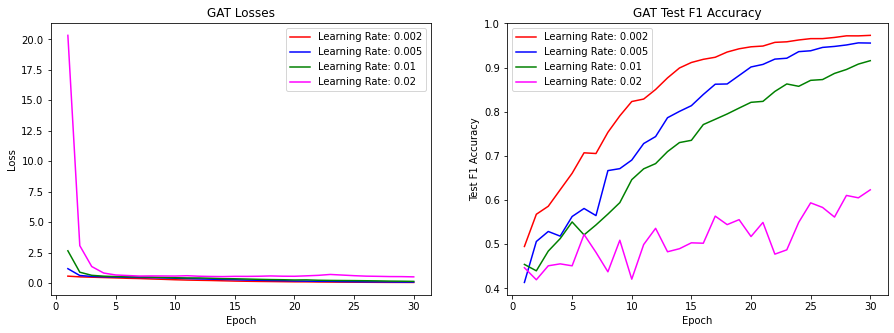

In [21]:
import matplotlib.pyplot as plt
from google.colab import files

#learning rates to iterate through
learning_rates = [0.002, 0.005, 0.01, 0.02]
colour_cycle = ['red', 'blue', 'green', 'magenta']
fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
for i, lr in enumerate(learning_rates):

  class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        #first layer taking nodes from input graph with 50 features which map to 256 output channels
        #4 attention heads used in this layer
        self.conv1 = GATConv(train_dataset.num_features, 256, heads=4)
        #linear layer, matrix multiplication of weights and layer inputs followed by bias addition
        self.lin1 = torch.nn.Linear(train_dataset.num_features, 4 * 256)
        self.conv2 = GATConv(4 * 256, 256, heads=4)
        self.lin2 = torch.nn.Linear(4 * 256, 4 * 256)
        self.conv3 = GATConv(4 * 256, train_dataset.num_classes, heads=6,
                            concat=False)
        self.lin3 = torch.nn.Linear(4 * 256, train_dataset.num_classes)

    def forward(self, x, edge_index):
        x = F.elu(self.conv1(x, edge_index) + self.lin1(x))
        x = F.elu(self.conv2(x, edge_index) + self.lin2(x))
        x = self.conv3(x, edge_index) + self.lin3(x)
        return x


  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model = Net().to(device)
  loss_op = torch.nn.BCEWithLogitsLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)#0.05) #lr previously 0.005
  def train():
      model.train()

      total_loss = 0
      for data in train_loader:
          data = data.to(device)
          optimizer.zero_grad()
          loss = loss_op(model(data.x, data.edge_index), data.y)
          total_loss += loss.item() * data.num_graphs
          loss.backward()
          optimizer.step()
      return total_loss / len(train_loader.dataset)


  @torch.no_grad()
  def test(loader):
      model.eval()

      ys, preds = [], []
      for data in loader:
          ys.append(data.y)
          out = model(data.x.to(device), data.edge_index.to(device))
          preds.append((out > 0).float().cpu())

      y, pred = torch.cat(ys, dim=0).numpy(), torch.cat(preds, dim=0).numpy()
      return f1_score(y, pred, average='micro') if pred.sum() > 0 else 0


  GAT_Epochs = []
  GAT_Loss = []
  GAT_ValF1 = []
  GAT_TestF1 = []

  for epoch in range(1, 31): #31
      loss = train()
      val_f1 = test(val_loader)
      test_f1 = test(test_loader)
      GAT_Epochs.append(epoch)
      GAT_Loss.append(loss)
      GAT_ValF1.append(val_f1)
      GAT_TestF1.append(test_f1)
      print(f'Learning rate: {lr}, Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_f1:.4f}, '
            f'Test: {test_f1:.4f}')
  

  ax1.plot(GAT_Epochs, GAT_Loss, color=colour_cycle[i], label=f'Learning Rate: {lr}')
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('Loss')
  ax1.set_title('GAT Losses')
  ax1.legend()

  ax2.plot(GAT_Epochs, GAT_TestF1, color=colour_cycle[i], label=f'Learning Rate: {lr}')
  ax2.set_xlabel('Epoch')
  ax2.set_ylabel('Test F1 Accuracy')
  ax2.set_title('GAT Test F1 Accuracy')
  ax2.legend()

  torch.save(model.state_dict(), path + "model_" + str(lr) +".pt")

fig1 = ax2.get_figure()
fig1.savefig('GAT_Performance_Learning_Rates.png')
files.download('GAT_Performance_Learning_Rates.png')

plt.show()

##5 - Under The Hood
Curious to see what is under the hood, what is in my model..

In [19]:
print(model)

Net(
  (conv1): GATConv(50, 256, heads=4)
  (lin1): Linear(in_features=50, out_features=1024, bias=True)
  (conv2): GATConv(1024, 256, heads=4)
  (lin2): Linear(in_features=1024, out_features=1024, bias=True)
  (conv3): GATConv(1024, 121, heads=6)
  (lin3): Linear(in_features=1024, out_features=121, bias=True)
)


In [20]:
#Curious to see what some of the parameters contain
counter = 0
for name, param in model.named_parameters():
    print(name, param)
    counter += 1
    if counter == 10:
        break


conv1.att_src Parameter containing:
tensor([[[-0.0027,  0.1161, -0.1178,  ..., -0.1504, -0.0573,  0.0073],
         [ 0.0199,  0.0072,  0.0011,  ...,  0.1116,  0.0129, -0.0126],
         [-0.1062,  0.1375, -0.0347,  ...,  0.1276, -0.0783,  0.0200],
         [-0.1285,  0.1623,  0.0782,  ..., -0.0017,  0.1126, -0.0540]]],
       requires_grad=True)
conv1.att_dst Parameter containing:
tensor([[[ 0.0819,  0.1094,  0.0458,  ...,  0.0691,  0.0932, -0.0945],
         [-0.1507, -0.0711,  0.0021,  ..., -0.0524, -0.0509,  0.1096],
         [ 0.0518, -0.0011, -0.0318,  ...,  0.0570, -0.0244, -0.0160],
         [ 0.1087,  0.0280, -0.0011,  ...,  0.1166, -0.1400, -0.1281]]],
       requires_grad=True)
conv1.bias Parameter containing:
tensor([-0.0329,  0.0110,  0.0071,  ..., -0.0168, -0.0329,  0.0326],
       requires_grad=True)
conv1.lin_src.weight Parameter containing:
tensor([[ 0.0541,  0.0677, -0.0353,  ...,  0.0116,  0.0399, -0.0235],
        [ 0.0549, -0.0523,  0.0400,  ...,  0.0197, -0.0344, 